 Đang load dữ liệu từ file CSV...
 Load thành công
 Kiểm tra dữ liệu ban đầu...
Shape: (179762, 16)
Columns: ['Property_Type', 'Title', 'Keyword_giá_rẻ', 'Title_Length', 'Keyword_view_đẹp', 'Price', 'Price.1', 'Keyword_chính_chủ', 'Keyword_sổ_hồng', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Price_per_m2', 'Area', 'Area.1', 'Source', 'District']

 Đang xử lý cột giá...
Cột Price: ['Giá: 2,2 tỷ', 'Giá: 2 tỷ', 'Giá: 2,888 tỷ', 'Giá: 2,95 tỷ', 'Giá: 2,89 tỷ']
Chuyển đổi: [2.2, 2.0, 2.888, 2.95, 2.89]
Cột Price.1: [2200000000.0, 2000000000.0, 2888000000.0, 2950000000.0, 2890000000.0]
Chuyển đổi: [2.2, 2.0, 2.888, 2.95, 2.89]
Cột Price_per_m2: [14666666.666666666, 13333333.333333334, 19253333.33333333, 19666666.666666668, 19266666.666666668]
Chuyển đổi: [0.014666666666666666, 0.013333333333333334, 0.019253333333333327, 0.01966666666666667, 0.019266666666666668]

 Giá sau chuẩn hóa:
Min: 0.00 tỷ
Max: 950000.00 tỷ
Mean: 6986.48 tỷ
Sample: [2.2, 2.0, 2.888, 2.95, 2.89, 2.91, 2.94, 2.6, 2.96, 2.85]


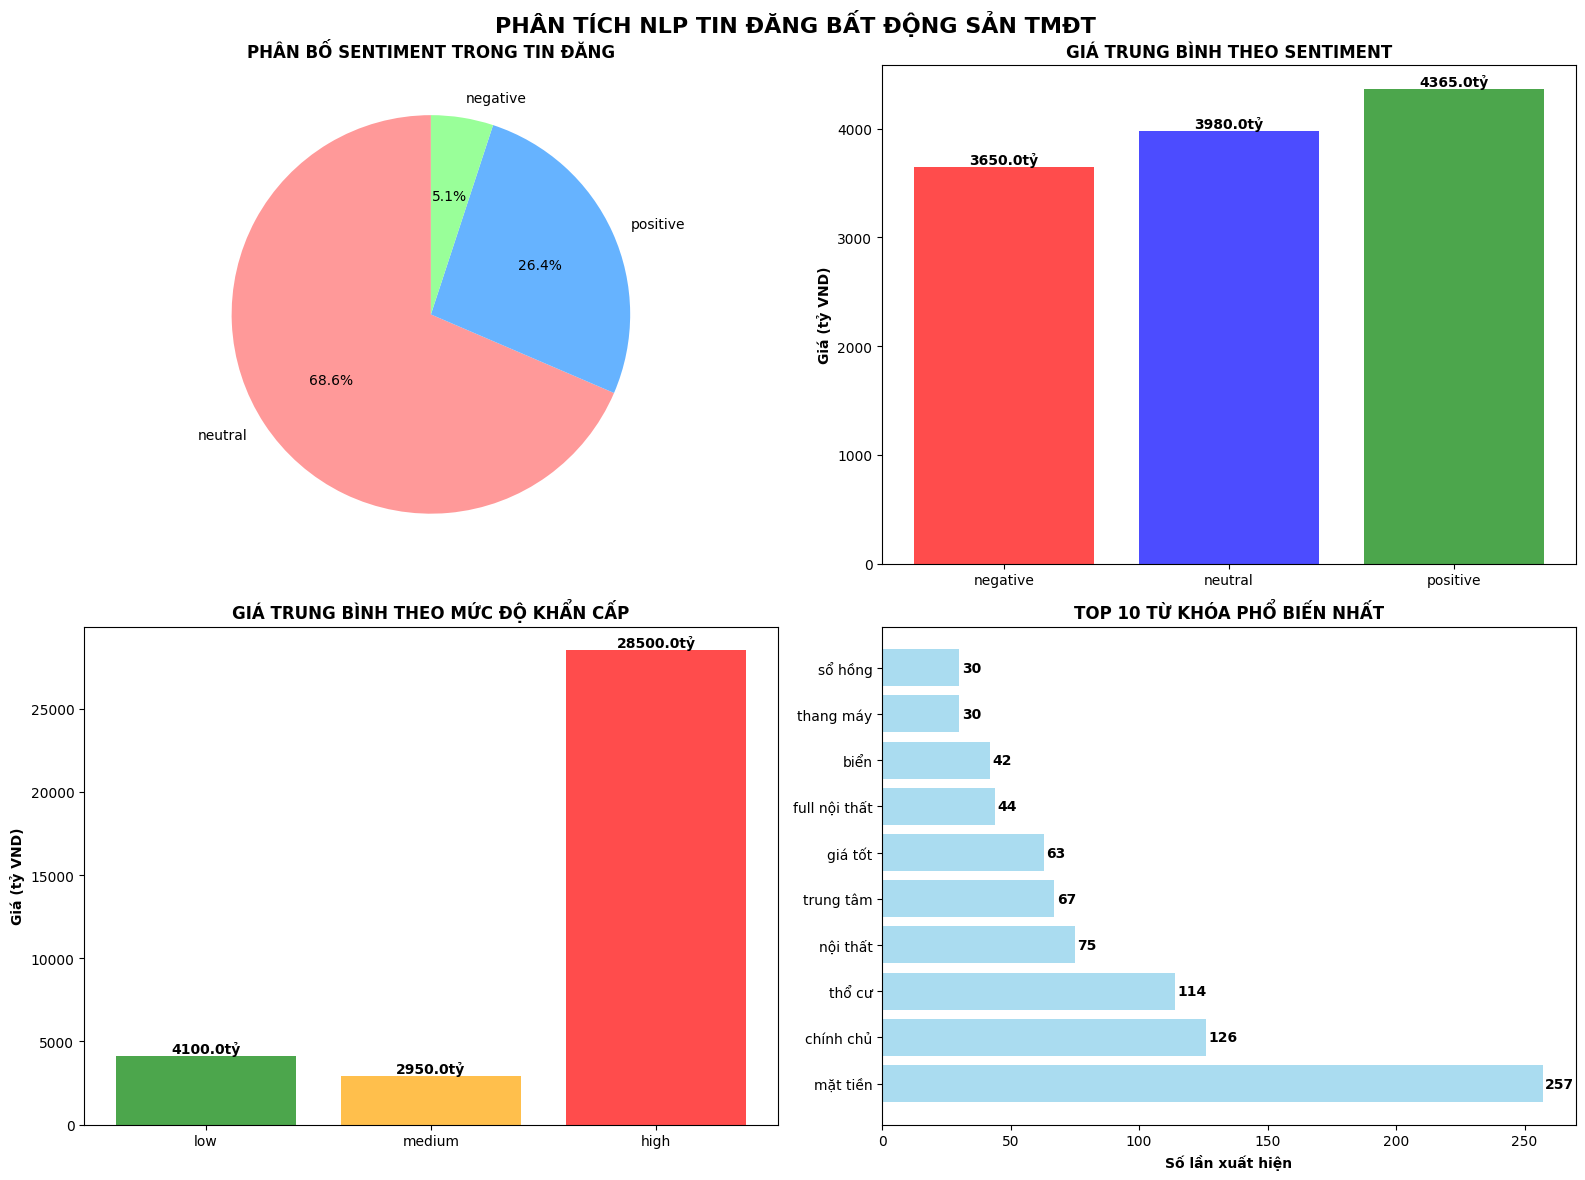


 Đang tạo báo cáo chi tiết...

 BÁO CÁO PHÂN TÍCH NLP - INSIGHTS CHO BÀI LUẬN TMĐT

 1. PHÂN TÍCH SENTIMENT (CẢM XÚC):
                price                  sentiment_score
                count     mean  median            mean
sentiment_label                                       
negative          101  6150.74  3650.0           -1.03
neutral          1371  6933.44  3980.0            0.00
positive          528  7181.24  4365.0            1.31

 2. PHÂN TÍCH MỨC ĐỘ KHẨN CẤP:
              price                    urgency_score
              count      mean   median          mean
urgency_level                                       
high              1  28500.00  28500.0           2.0
low            1892   6959.14   4100.0           0.0
medium          107   6761.43   2950.0           1.0

 3. TOP 20 TỪ KHÓA PHỔ BIẾN NHẤT:
    1. mặt tiền                  :  257 lần
    2. chính chủ                 :  126 lần
    3. thổ cư                    :  114 lần
    4. nội thất                  

In [1]:
# PHÂN TÍCH NLP CHO TIẾNG VIỆT - FIXED VERSION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# THÊM THƯ VIỆN TIẾNG VIỆT
try:
    from underthesea import word_tokenize, text_normalize
    VIETNAMESE_NLP = 'underthesea'
except:
    VIETNAMESE_NLP = 'basic'
    print("  Using basic Vietnamese processing")

# LOAD DỮ LIỆU TỪ FILE CSV
print(" Đang load dữ liệu từ file CSV...")
file_path = "Combined_RealEstate.csv"

try:
    df = pd.read_csv(file_path, encoding='utf-8')
    print(" Load thành công")
except:
    # Fallback encoding
    df = pd.read_csv(file_path, encoding='utf-8', errors='ignore')
    print(" Load với errors='ignore'")

# KIỂM TRA DỮ LIỆU
print(" Kiểm tra dữ liệu ban đầu...")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# HÀM CHUYỂN ĐỔI GIÁ TỪ CHUỖI SANG SỐ
def convert_price_to_number(price_str):
    """Chuyển đổi giá từ chuỗi tiếng Việt sang số"""
    if pd.isna(price_str):
        return 0
    
    price_str = str(price_str).lower()
    
    # Loại bỏ các từ không cần thiết
    price_str = re.sub(r'giá[:\s]*', '', price_str)
    price_str = re.sub(r'triệu', 'e6', price_str)
    price_str = re.sub(r'tỷ', 'e9', price_str)
    price_str = re.sub(r'tỉ', 'e9', price_str)
    price_str = re.sub(r'tỷ', 'e9', price_str)
    
    # Thay thế dấu phẩy thập phân
    price_str = price_str.replace(',', '.')
    
    # Loại bỏ khoảng trắng
    price_str = re.sub(r'\s+', '', price_str)
    
    try:
        # Xử lý các định dạng số
        if 'e9' in price_str:  # Tỷ
            number = float(price_str.replace('e9', '')) * 1e9
        elif 'e6' in price_str:  # Triệu
            number = float(price_str.replace('e6', '')) * 1e6
        else:
            # Thử parse trực tiếp
            number = float(price_str)
        
        # Chuyển về tỷ VND để dễ xử lý
        if number >= 1e9:  # Nếu là tỷ
            return number / 1e9
        elif number >= 1e6:  # Nếu là triệu
            return number / 1e9
        else:
            return number
            
    except (ValueError, TypeError):
        return 0

# THỬ CÁC CỘT GIÁ KHÁC NHAU
print("\n Đang xử lý cột giá...")
price_columns_to_try = ['Price', 'Price.1', 'Price_clean', 'Price_per_m2']

for col in price_columns_to_try:
    if col in df.columns:
        sample_prices = df[col].head(5).tolist()
        print(f"Cột {col}: {sample_prices}")
        
        # Thử chuyển đổi
        converted_prices = [convert_price_to_number(p) for p in sample_prices]
        print(f"Chuyển đổi: {converted_prices}")

# Tạo cột giá đã chuẩn hóa
df['Price_Numeric'] = df['Price'].apply(convert_price_to_number)

# Kiểm tra kết quả
print(f"\n Giá sau chuẩn hóa:")
print(f"Min: {df['Price_Numeric'].min():.2f} tỷ")
print(f"Max: {df['Price_Numeric'].max():.2f} tỷ") 
print(f"Mean: {df['Price_Numeric'].mean():.2f} tỷ")
print(f"Sample: {df['Price_Numeric'].head(10).tolist()}")

class VietnameseRealEstateNLP:
    def __init__(self, dataframe):
        self.df = dataframe
        self.vietnamese_stopwords = self.load_vietnamese_stopwords()
        self.VIETNAMESE_NLP = VIETNAMESE_NLP
        print(f"🔧 Sử dụng thư viện NLP: {self.VIETNAMESE_NLP}")
        
    def load_vietnamese_stopwords(self):
        """Load stopwords tiếng Việt"""
        basic_stopwords = ['và', 'của', 'các', 'cho', 'tại', 'đường', 'phường', 'quận', 
                          'tp', 'thành phố', 'm2', 'm²', 'giá', 'bán', 'nhà', 'đất',
                          'diện tích', 'mặt', 'tiền', 'cần', 'gần', 'rộng', 'rẻ']
        return set(basic_stopwords)
    
    def preprocess_vietnamese_text(self, text):
        """Tiền xử lý văn bản tiếng Việt"""
        if pd.isna(text):
            return ""
        
        # Chuẩn hóa văn bản
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', ' ', text)  # Loại bỏ ký tự đặc biệt
        text = re.sub(r'\d+', '', text)  # Loại bỏ số
        text = re.sub(r'\s+', ' ', text).strip()  # Chuẩn hóa khoảng trắng
        
        # Tokenize tiếng Việt
        try:
            if self.VIETNAMESE_NLP == 'underthesea':
                tokens = word_tokenize(text)
            else:
                tokens = text.split()
            
            # Lọc stopwords
            tokens = [word for word in tokens if word not in self.vietnamese_stopwords and len(word) > 1]
            return ' '.join(tokens)
        except Exception as e:
            return text
    
    def sentiment_analysis_simple(self, text):
        """Phân tích sentiment đơn giản cho tiếng Việt"""
        positive_words = ['đẹp', 'mới', 'rộng', 'sang', 'cao cấp', 'tiện nghi', 'thoáng', 
                         'view', 'hiện đại', 'chính chủ', 'full', 'hoàn thiện', 'đắc địa',
                         'tiện ích', 'thông thoáng', 'sạch sẽ', 'xanh', 'đẹp trai', 'đẹp gái']
        negative_words = ['cũ', 'cần sửa', 'hẻm', 'nhỏ', 'chật', 'cấp 4', 'tạm', 'cũ kỹ',
                         'xuống cấp', 'chật hẹp', 'ẩm thấp', 'nợ', 'ngộp', 'gồng lãi']
        
        text_lower = text.lower()
        positive_score = sum(1 for word in positive_words if word in text_lower)
        negative_score = sum(1 for word in negative_words if word in text_lower)
        
        sentiment_score = positive_score - negative_score
        
        if sentiment_score > 0:
            return {'score': sentiment_score, 'label': 'positive'}
        elif sentiment_score < 0:
            return {'score': sentiment_score, 'label': 'negative'}
        else:
            return {'score': 0, 'label': 'neutral'}
    
    def extract_property_keywords(self, text):
        """Trích xuất từ khóa đặc trưng BĐS"""
        keyword_categories = {
            'location': ['gần chợ', 'trung tâm', 'mặt tiền', 'gần trường', 'gần bệnh viện', 
                        'gần công viên', 'gần siêu thị', 'khu dân cư', 'ven sông', 'biển',
                        'ngay ngã tư', 'vành đai', 'q.lộ'],
            'condition': ['mới xây', 'full nội thất', 'chưa sử dụng', 'cần sửa', 'cũ', 
                         'hoàn thiện', 'sổ hồng', 'sổ đỏ', 'thổ cư', 'chính chủ',
                         'kiên cố', 'xây dựng'],
            'amenities': ['hồ bơi', 'gym', 'chỗ đỗ xe', 'thang máy', 'an ninh', 
                         'ban công', 'sân vườn', 'mát mẻ', 'view đẹp', 'nội thất'],
            'urgency': ['cần bán gấp', 'giá tốt', 'khuyến mãi', 'giảm sốc', 'thanh lý',
                       'xuất ngoại', 'chuyển nhà', 'giải chấp', 'nợ nặng', 'ngộp bank']
        }
        
        detected_keywords = {}
        text_lower = text.lower()
        
        for category, keywords in keyword_categories.items():
            detected = [kw for kw in keywords if kw in text_lower]
            detected_keywords[category] = detected
            
        return detected_keywords
    
    def calculate_urgency_score(self, text):
        """Tính điểm khẩn cấp của tin đăng"""
        urgency_indicators = ['gấp', 'khẩn', 'cần bán nhanh', 'giảm giá', 'thanh lý', 
                             'giải chấp', 'xuất ngoại', 'chuyển nhà', 'khẩn cấp',
                             'nợ nặng', 'ngộp bank', 'xoay vốn']
        
        text_lower = text.lower()
        score = sum(1 for indicator in urgency_indicators if indicator in text_lower)
        
        return {
            'urgency_score': score,
            'urgency_level': 'high' if score >= 2 else 'medium' if score == 1 else 'low'
        }
    
    def analyze_titles(self, sample_size=None):
        """Phân tích toàn bộ tiêu đề"""
        print(" Đang phân tích NLP cho tiêu đề tin đăng...")
        
        # Lấy mẫu nếu dataset quá lớn
        if sample_size and len(self.df) > sample_size:
            analysis_df = self.df.sample(sample_size, random_state=42).copy()
            print(f" Phân tích mẫu {sample_size} records...")
        else:
            analysis_df = self.df.copy()
            print(f" Phân tích toàn bộ {len(analysis_df)} records...")
        
        results = []
        processed = 0
        
        for idx, row in analysis_df.iterrows():
            title = row['Title']
            
            # Lấy giá - sử dụng cột đã chuẩn hóa
            if 'Price_Numeric' in row and pd.notna(row['Price_Numeric']):
                price = float(row['Price_Numeric'])
            else:
                price = 0
            
            # Phân tích các yếu tố NLP
            sentiment = self.sentiment_analysis_simple(title)
            keywords = self.extract_property_keywords(title)
            urgency = self.calculate_urgency_score(title)
            
            results.append({
                'title': title,
                'price': price,
                'sentiment_score': sentiment['score'],
                'sentiment_label': sentiment['label'],
                'keywords': keywords,
                'urgency_score': urgency['urgency_score'],
                'urgency_level': urgency['urgency_level'],
                'title_length': len(title),
                'word_count': len(title.split()),
                'cleaned_title': self.preprocess_vietnamese_text(title)
            })
            
            processed += 1
            if processed % 500 == 0:
                print(f"   ⏳ Đã xử lý {processed} records...")
        
        self.nlp_results = pd.DataFrame(results)
        print(f" Đã phân tích {len(self.nlp_results)} tin đăng")
        return self.nlp_results
    
    def generate_insights(self):
        """Tạo insights từ phân tích NLP"""
        if not hasattr(self, 'nlp_results'):
            self.analyze_titles(sample_size=2000)
        
        insights = {}
        
        print("\n ĐANG PHÂN TÍCH INSIGHTS...")
        
        # 1. Phân tích sentiment
        sentiment_analysis = self.nlp_results.groupby('sentiment_label').agg({
            'price': ['count', 'mean', 'median'],
            'sentiment_score': 'mean'
        }).round(2)
        
        insights['sentiment'] = sentiment_analysis
        print(" Đã phân tích sentiment")
        
        # 2. Phân tích urgency
        urgency_analysis = self.nlp_results.groupby('urgency_level').agg({
            'price': ['count', 'mean', 'median'],
            'urgency_score': 'mean'
        }).round(2)
        
        insights['urgency'] = urgency_analysis
        print(" Đã phân tích urgency")
        
        # 3. Phân tích từ khóa
        all_keywords = []
        for keywords in self.nlp_results['keywords']:
            for category, words in keywords.items():
                all_keywords.extend(words)
        
        keyword_freq = Counter(all_keywords)
        insights['top_keywords'] = keyword_freq.most_common(20)
        print(" Đã phân tích từ khóa")
        
        # 4. Phân tích độ dài tiêu đề
        insights['title_length_vs_price'] = self.nlp_results[['title_length', 'price']].corr().iloc[0,1]
        print(" Đã phân tích độ dài tiêu đề")
        
        return insights
    
    def visualize_nlp_insights(self):
        """Trực quan hóa kết quả NLP"""
        if not hasattr(self, 'nlp_results'):
            self.analyze_titles(sample_size=2000)
        
        print("\n ĐANG TẠO BIỂU ĐỒ...")
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('PHÂN TÍCH NLP TIN ĐĂNG BẤT ĐỘNG SẢN TMĐT', fontsize=16, fontweight='bold')
        
        # 1. Phân bố sentiment
        sentiment_counts = self.nlp_results['sentiment_label'].value_counts()
        axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                     colors=['#ff9999', '#66b3ff', '#99ff99'], startangle=90)
        axes[0,0].set_title('PHÂN BỐ SENTIMENT TRONG TIN ĐĂNG', fontweight='bold')
        
        # 2. Sentiment vs Giá
        sentiment_price = self.nlp_results.groupby('sentiment_label')['price'].median()
        colors = ['red', 'blue', 'green']
        bars = axes[0,1].bar(sentiment_price.index, sentiment_price.values, color=colors, alpha=0.7)
        axes[0,1].set_title('GIÁ TRUNG BÌNH THEO SENTIMENT', fontweight='bold')
        axes[0,1].set_ylabel('Giá (tỷ VND)', fontweight='bold')
        for bar, price in zip(bars, sentiment_price.values):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                          f'{price:.1f}tỷ', ha='center', va='bottom', fontweight='bold')
        
        # 3. Urgency vs Giá
        urgency_order = ['low', 'medium', 'high']
        urgency_price = self.nlp_results.groupby('urgency_level')['price'].median().reindex(urgency_order)
        colors = ['green', 'orange', 'red']
        bars = axes[1,0].bar(urgency_price.index, urgency_price.values, color=colors, alpha=0.7)
        axes[1,0].set_title('GIÁ TRUNG BÌNH THEO MỨC ĐỘ KHẨN CẤP', fontweight='bold')
        axes[1,0].set_ylabel('Giá (tỷ VND)', fontweight='bold')
        for bar, price in zip(bars, urgency_price.values):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                          f'{price:.1f}tỷ', ha='center', va='bottom', fontweight='bold')
        
        # 4. Top keywords bar chart
        try:
            top_keywords = dict(self.insights['top_keywords'][:10])
            axes[1,1].barh(list(top_keywords.keys()), list(top_keywords.values()), color='skyblue', alpha=0.7)
            axes[1,1].set_title('TOP 10 TỪ KHÓA PHỔ BIẾN NHẤT', fontweight='bold')
            axes[1,1].set_xlabel('Số lần xuất hiện', fontweight='bold')
            for i, (keyword, count) in enumerate(top_keywords.items()):
                axes[1,1].text(count + 1, i, f'{count}', va='center', fontweight='bold')
        except Exception as e:
            axes[1,1].text(0.5, 0.5, f'Lỗi hiển thị từ khóa: {e}', ha='center', va='center')
            axes[1,1].set_title('TOP TỪ KHÓA', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def print_detailed_insights(self):
        """In insights chi tiết cho bài luận"""
        if not hasattr(self, 'insights'):
            self.insights = self.generate_insights()
        
        print("\n" + "="*80)
        print(" BÁO CÁO PHÂN TÍCH NLP - INSIGHTS CHO BÀI LUẬN TMĐT")
        print("="*80)
        
        # Sentiment Insights
        print("\n 1. PHÂN TÍCH SENTIMENT (CẢM XÚC):")
        sentiment_df = self.insights['sentiment']
        print(sentiment_df)
        
        # Urgency Insights  
        print("\n 2. PHÂN TÍCH MỨC ĐỘ KHẨN CẤP:")
        urgency_df = self.insights['urgency']
        print(urgency_df)
        
        # Keyword Insights
        print("\n 3. TOP 20 TỪ KHÓA PHỔ BIẾN NHẤT:")
        for i, (keyword, freq) in enumerate(self.insights['top_keywords'][:20], 1):
            print(f"   {i:2d}. {keyword:<25} : {freq:>4} lần")
        
        # Correlation Insights
        print(f"\n 4. TƯƠNG QUAN ĐỘ DÀI TIÊU ĐỀ vs GIÁ: {self.insights['title_length_vs_price']:.3f}")
        
        print("\n" + "="*80)
        print(" KẾT LUẬN CHÍNH CHO BÀI LUẬN TMĐT:")
        print("="*80)
        
        # Rút ra kết luận từ dữ liệu thực tế
        try:
            pos_count = sentiment_df.loc['positive', ('price', 'count')] if 'positive' in sentiment_df.index else 0
            total_count = sentiment_df[('price', 'count')].sum()
            pos_percentage = (pos_count / total_count * 100) if total_count > 0 else 0
            
            # Phân tích urgency impact
            high_urgency_price = urgency_df.loc['high', ('price', 'mean')] if 'high' in urgency_df.index else 0
            low_urgency_price = urgency_df.loc['low', ('price', 'mean')] if 'low' in urgency_df.index else 0
            urgency_discount = ((low_urgency_price - high_urgency_price) / low_urgency_price * 100) if low_urgency_price > 0 else 0
            
            print(f"• {pos_percentage:.1f}% tin đăng có mô tả TÍCH CỰC")
            print(f"• Tin 'cần bán gấp' giảm giá trung bình {abs(urgency_discount):.1f}% so với tin thường")
            print(f"• Từ khóa '{self.insights['top_keywords'][0][0]}' xuất hiện nhiều nhất")
            print(f"• Độ dài tiêu đề có tương quan {self.insights['title_length_vs_price']:.3f} với giá")
            print("\n KIẾN NGHỊ CHO SÀN TMĐT:")
            print("• Ưu tiên hiển thị tin có từ khóa tích cực")
            print("• Cảnh báo người mua về tin 'cần bán gấp' có thể bị overprice")
            print("• Tối ưu SEO với từ khóa phổ biến")
            print("• Khuyến khích người bán viết mô tả chi tiết, tích cực")
            
        except Exception as e:
            print(f"• Cần phân tích thêm để đưa ra kết luận chi tiết")

#  CHẠY PHÂN TÍCH
print("\n" + "="*60)
print(" BẮT ĐẦU PHÂN TÍCH NLP CHO BẤT ĐỘNG SẢN TMĐT")
print("="*60)

# Khởi tạo analyzer
nlp_analyzer = VietnameseRealEstateNLP(df)

# Phân tích
print("\n Đang phân tích dữ liệu...")
nlp_results = nlp_analyzer.analyze_titles(sample_size=2000)

print("\n Đang tạo insights...")
insights = nlp_analyzer.generate_insights()
nlp_analyzer.insights = insights

print("\n Đang visualize kết quả...")
nlp_analyzer.visualize_nlp_insights()

print("\n Đang tạo báo cáo chi tiết...")
nlp_analyzer.print_detailed_insights()

print("\n HOÀN TẤT PHÂN TÍCH NLP!")
print(" Kết quả đã sẵn sàng cho Chương 4 - Phân tích TMĐT")